In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from scipy.sparse import csr_matrix
import pickle
from scipy.sparse import save_npz
import matplotlib.pyplot as plt

# EDA

In [2]:
current_dir = Path.cwd()
user_item_file_path = current_dir.parent / "data" / "data_and_test_files" / "user_item_rating_table_train.csv"
df2 = pd.read_csv(user_item_file_path,index_col=0)
df2.head()

,user_id,parent_asin,rating,timestamp
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B009RTBRVG,5.0,1349041740000
1,AGGZ357AO26RQZVRLGU4D4N52DZQ,B003MZ01CM,1.0,1370958618000
2,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07L6QT33F,5.0,1440038761000
3,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07V6PKCCG,3.0,1483320893000
5,AGGZ357AO26RQZVRLGU4D4N52DZQ,B0BNP511CS,5.0,1490800837000


In [3]:
df2.dtypes

user_id         object
parent_asin     object
rating         float64
timestamp        int64
dtype: object

In [4]:
# Calculate the average rating
average_rating = df2['rating'].mean()

# Calculate the MSE
mse = np.mean((df2['rating'] - average_rating) ** 2)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 1.3019907962466766


In [5]:
# Overall average rating
global_avg = df2['rating'].mean()

# Item bias
item_bias = df2.groupby('parent_asin')['rating'].mean() - global_avg
item_bias = item_bias.reset_index().rename(columns={'rating': 'item_bias'})

# User bias
user_bias = df2.groupby('user_id')['rating'].mean() - global_avg
user_bias = user_bias.reset_index().rename(columns={'rating': 'user_bias'})

# Merge biases with the main DataFrame for easier access (optional)
df_with_biases = df2.merge(item_bias, on='parent_asin', how='left')
df_with_biases = df_with_biases.merge(user_bias, on='user_id', how='left')
df_with_biases['predicted_rating'] = global_avg + df_with_biases['item_bias'] + df_with_biases['user_bias']

df_with_biases.head()

,user_id,parent_asin,rating,timestamp,item_bias,user_bias,predicted_rating
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B009RTBRVG,5.0,1349041740000,0.095113,-0.521554,3.895113
1,AGGZ357AO26RQZVRLGU4D4N52DZQ,B003MZ01CM,1.0,1370958618000,-0.332249,-0.521554,3.467751
2,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07L6QT33F,5.0,1440038761000,0.271039,-0.521554,4.071039
3,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07V6PKCCG,3.0,1483320893000,0.259091,-0.521554,4.059091
4,AGGZ357AO26RQZVRLGU4D4N52DZQ,B0BNP511CS,5.0,1490800837000,0.355214,-0.521554,4.155214


In [6]:
# Calculate MSE
mse_with_biases = np.mean((df_with_biases['rating'] - df_with_biases['predicted_rating']) ** 2)
print(f"Mean Squared Error (MSE) for null model only with biases: {mse_with_biases}")

Mean Squared Error (MSE) for null model only with biases: 0.8961885025627692


In [7]:
average_rating

4.321553826471724

In [8]:
# Calculate interaction counts per user
user_interactions = df2.groupby("user_id").size()

# Calculate min, max, median, and mean of interactions per user
min_interactions = user_interactions.min()
max_interactions = user_interactions.max()
median_interactions = user_interactions.median()
mean_interactions = user_interactions.mean()

# Display results
print("Minimum interactions per user:", min_interactions)
print("Maximum interactions per user:", max_interactions)
print("Median interactions per user:", median_interactions)
print("Mean interactions per user:", mean_interactions)

Minimum interactions per user: 1
Maximum interactions per user: 1438
Median interactions per user: 6.0
Mean interactions per user: 8.32105814471862


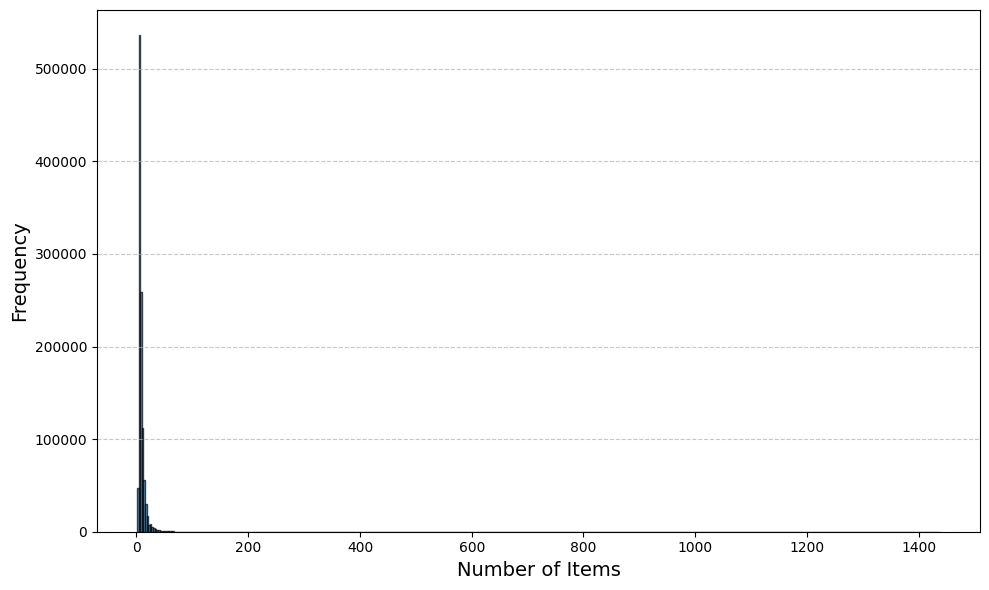

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(user_interactions, bins=500, edgecolor="k", alpha=0.7)
plt.xlabel("Number of Items", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("user_interactions_distribution.png", dpi=1000, bbox_inches='tight')
plt.show()

In [10]:
## We can see a long tail distribution

In [11]:
# Find the number of users with less than 5 items in order to decide how to split to train-val-test
users_less_than_5 = (user_interactions < 5).sum()

print(f"Number of users with less than 5 items: {users_less_than_5}") # We will use it for the splitting stage

Number of users with less than 5 items: 187361


# Pre Process

In [14]:
# Step 1: Create mappings for users and items
user_mapping = {user: idx for idx, user in enumerate(df2['user_id'].unique())}
item_mapping = {item: idx for idx, item in enumerate(df2['parent_asin'].unique())}

In [16]:
len(user_mapping), len(item_mapping)

(1096901, 198771)

In [17]:
# Step 2: Create inverse mappings for future reference
inverse_user_mapping = {v: k for k, v in user_mapping.items()}
inverse_item_mapping = {v: k for k, v in item_mapping.items()}

In [18]:
# Step 3: Add numeric indices to the DataFrame
df2['user_idx'] = df2['user_id'].map(user_mapping)
df2['item_idx'] = df2['parent_asin'].map(item_mapping)

In [19]:
df2.head()

,user_id,parent_asin,rating,timestamp,user_idx,item_idx
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B009RTBRVG,5.0,1349041740000,0,0
1,AGGZ357AO26RQZVRLGU4D4N52DZQ,B003MZ01CM,1.0,1370958618000,0,1
2,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07L6QT33F,5.0,1440038761000,0,2
3,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07V6PKCCG,3.0,1483320893000,0,3
5,AGGZ357AO26RQZVRLGU4D4N52DZQ,B0BNP511CS,5.0,1490800837000,0,4


## Save data with idx

In [24]:
# user_item_new_file_path = current_dir.parent / "data" / "data_and_test_files" / "user_item_rating_table_train_with_idx.csv"
# df2.to_csv(user_item_new_file_path, index=False)

In [27]:
# dff = pd.read_csv(user_item_new_file_path)
# dff

## Create the crs matrix

In [36]:
# Step 4: Create the user-item sparse matrix
num_users = len(user_mapping)
num_items = len(item_mapping)

user_item_matrix = csr_matrix((df2['rating'], (df2['user_idx'], df2['item_idx'])),shape=(num_users, num_items))

In [37]:
user_item_matrix

<1096901x198771 sparse matrix of type '<class 'numpy.float64'>'
	with 9127377 stored elements in Compressed Sparse Row format>

In [38]:
# Step 6: Verify the matrix
print(f"Shape of user-item matrix: {user_item_matrix.shape}")
print(f"Number of non-zero entries: {user_item_matrix.nnz}")

Shape of user-item matrix: (1096901, 198771)
Number of non-zero entries: 9127377


In [39]:
print(user_item_matrix)

  (0, 0)	5.0
  (0, 1)	1.0
  (0, 2)	5.0
  (0, 3)	3.0
  (0, 4)	5.0
  (1, 5)	5.0
  (1, 6)	5.0
  (1, 7)	5.0
  (1, 8)	5.0
  (1, 9)	5.0
  (1, 10)	2.0
  (2, 11)	3.0
  (2, 12)	3.0
  (2, 13)	3.0
  (2, 14)	5.0
  (2, 15)	4.0
  (2, 16)	5.0
  (3, 17)	5.0
  (3, 18)	5.0
  (3, 19)	4.0
  (3, 20)	5.0
  (3, 21)	5.0
  (3, 22)	5.0
  (3, 23)	5.0
  (3, 24)	4.0
  :	:
  (1096896, 11404)	5.0
  (1096896, 16937)	5.0
  (1096896, 60244)	4.0
  (1096896, 82390)	5.0
  (1096896, 115951)	5.0
  (1096896, 163716)	5.0
  (1096897, 72705)	5.0
  (1096897, 87339)	5.0
  (1096897, 115126)	5.0
  (1096897, 151748)	5.0
  (1096897, 161020)	5.0
  (1096898, 9335)	5.0
  (1096898, 9974)	5.0
  (1096898, 38255)	5.0
  (1096898, 49449)	5.0
  (1096898, 93607)	5.0
  (1096899, 10643)	5.0
  (1096899, 21130)	5.0
  (1096899, 31787)	5.0
  (1096899, 32852)	5.0
  (1096899, 92761)	5.0
  (1096900, 25515)	4.0
  (1096900, 76857)	5.0
  (1096900, 155119)	1.0
  (1096900, 183765)	1.0


# Update 20/2 - Split to train/val (no test)

In [6]:
# Parameters for splitting
m = 1  # Number of interactions for validation

In [15]:
# Load user and item mapping:
user_mapping_path = current_dir.parent / "data" / "pre_process" / "user_mapping.pkl"
item_mapping_path = current_dir.parent / "data" / "pre_process" / "item_mapping.pkl"
import pickle

# Load user and item mappings
with open(user_mapping_path, 'rb') as f:
    user_mapping = pickle.load(f)

with open(item_mapping_path, 'rb') as f:
    item_mapping = pickle.load(f)

# Add numeric indices to the DataFrame
df2['user_idx'] = df2['user_id'].map(user_mapping)
df2['item_idx'] = df2['parent_asin'].map(item_mapping)
df2

,user_id,parent_asin,rating,timestamp,user_idx,item_idx
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B009RTBRVG,5.0,1349041740000,0,0
1,AGGZ357AO26RQZVRLGU4D4N52DZQ,B003MZ01CM,1.0,1370958618000,0,1
2,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07L6QT33F,5.0,1440038761000,0,2
3,AGGZ357AO26RQZVRLGU4D4N52DZQ,B07V6PKCCG,3.0,1483320893000,0,3
5,AGGZ357AO26RQZVRLGU4D4N52DZQ,B0BNP511CS,5.0,1490800837000,0,4
...,...,...,...,...,...,...
10563583,AEQHNMSCENA2TJAJEFK5SFI3ZKXA,B09G9THPC6,5.0,1692552496934,1096899,92761
10563584,AFGBVYKTFNQH5NIHXNB5ANVPANXQ,B088D217BQ,1.0,1600792118191,1096900,183765
10563585,AFGBVYKTFNQH5NIHXNB5ANVPANXQ,B07WV5H4DN,1.0,1615811081145,1096900,155119
10563587,AFGBVYKTFNQH5NIHXNB5ANVPANXQ,B0BL3PQHR4,4.0,1693494834857,1096900,25515


In [18]:
df2.item_idx.isna().sum(),df2.user_idx.isna().sum()

(0, 0)

In [19]:
# Group interactions by user and split
grouped = df2.groupby("user_idx")

# Initialize lists for splits
train_data = []
val_data = []

for user_idx, group in grouped:
    interactions = group.sort_values(by="timestamp") # Sort within each user's interactions by timestamp
    num_interactions = len(interactions)

    # Split indices
    val_split_idx = -m

    # Append splits
    val_data.append(interactions.iloc[val_split_idx:])
    train_data.append(interactions.iloc[:val_split_idx])

In [21]:
num_users = 1096901
num_items = 198771

In [22]:
# Concatenate the lists of DataFrames
train_data_df = pd.concat(train_data)
val_data_df = pd.concat(val_data)

In [ ]:
# Create sparse matrices
train_matrix = csr_matrix((train_data_df['rating'], (train_data_df['user_idx'], train_data_df['item_idx'])), shape=(num_users, num_items))
val_matrix = csr_matrix((val_data_df['rating'], (val_data_df['user_idx'], val_data_df['item_idx'])), shape=(num_users, num_items))

### Save the train-val split

In [24]:
save_path = current_dir.parent / "data" / "pre_process"
# Save the sparse train-val-test
save_npz(save_path / 'train2.npz', train_matrix)
save_npz(save_path / 'val2.npz', val_matrix)

In [25]:
print(f"Train matrix shape: {train_matrix.shape}")
print(f"Validation matrix shape: {val_matrix.shape}")

Train matrix shape: (1096901, 198771)
Validation matrix shape: (1096901, 198771)


### real test data embedding

In [4]:
current_dir = Path.cwd()
test_pairwise_path = current_dir.parent / "data" / "data_and_test_files" / "cold_items_classification_test_format.csv"
test_rating_path = current_dir.parent / "data" / "data_and_test_files" / "cold_items_rating_prediction_test_format.csv"


In [7]:
test_pairwise = pd.read_csv(test_pairwise_path)
test_rating = pd.read_csv(test_rating_path)


In [16]:
unique_items_df1 = set(test_pairwise['item_0']).union(set(test_pairwise['item_1']))
unique_items_df2 = set(test_rating['parent_asin'])

# Combine both sets into one unique set
all_unique_items = list(unique_items_df1.union(unique_items_df2))

# Optional: Sort the list
all_unique_items.sort()

In [17]:
all_unique_items

['B0000AR2EL',
 'B0000AZ7KR',
 'B0000B35EG',
 'B0000DB9DR',
 'B0000UJH1S',
 'B0001ZUVAI',
 'B00024WASE',
 'B00024WC7S',
 'B0002V31Z8',
 'B000632SLU',
 'B00067U4WG',
 'B0006Z3HMW',
 'B00074KYC8',
 'B0007MV6PY',
 'B0007OW804',
 'B0007PN6EK',
 'B0007YYB90',
 'B0008161HC',
 'B00083DGY6',
 'B0009VC73I',
 'B0009WXUF6',
 'B000A7KB7U',
 'B000AP6KTA',
 'B000AR7RZY',
 'B000ARF6Z2',
 'B000AS7GJU',
 'B000AUFU8M',
 'B000B0J9HE',
 'B000B5OD4I',
 'B000BRF9XK',
 'B000E0V532',
 'B000EPCDC4',
 'B000EPCQA8',
 'B000EQ0BM2',
 'B000EQS1JW',
 'B000EQU0NW',
 'B000F44C6Y',
 'B000F4G5HS',
 'B000F4LK2I',
 'B000FHHD1W',
 'B000FHHDHG',
 'B000FVAUXQ',
 'B000FVE3DE',
 'B000G1VABG',
 'B000GA5YRS',
 'B000GA5YSC',
 'B000GAWSFO',
 'B000GAYQRM',
 'B000GAYQTU',
 'B000GB1R8M',
 'B000GB1RAU',
 'B000GE23C8',
 'B000GH09HQ',
 'B000GSM5N6',
 'B000GX8WAG',
 'B000H6BYI4',
 'B000H6PAGG',
 'B000HDNWFK',
 'B000HGK1VA',
 'B000HHRPE0',
 'B000HHSBSE',
 'B000J26CWE',
 'B000JFJUIE',
 'B000JMB3JQ',
 'B000KIE11Q',
 'B000KK0P3W',
 'B000KKO8

In [18]:
test_item_mapping = {item: idx for idx, item in enumerate(all_unique_items)}

In [24]:
inverse_item_mapping = {v: k for k, v in test_item_mapping.items()}

In [19]:

test_rating['item_idx'] = test_rating['parent_asin'].map(test_item_mapping)
test_pairwise['item0_idx'] = test_pairwise['item_0'].map(test_item_mapping)
test_pairwise['item1_idx'] = test_pairwise['item_1'].map(test_item_mapping)


In [21]:
test_rating

,user_id,parent_asin,rating,item_idx
0,AHSXXZHYMXDRVKC643TJZYQ7XGYA,B07S5H9R7X,-1,10523
1,AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ,B0C3Y37PSZ,-1,21743
2,AE2DWV6OPSOUHDZEZQBC2MRYAOXA,B09L4V5P21,-1,17006
3,AEYEP6B5W5QBNMM4OBQBQJDJ63SA,B097R4PPYN,-1,16000
4,AGF42GID7QWDCNFTJRCTMKAITJJA,B0C5MSSR5Y,-1,21893
...,...,...,...,...
74937,AEQ3EV3FNTDIUBZOCHU7GODYTM4A,B0B7JFNZPC,-1,19092
74938,AGQHSXFYWFADPXPIXJOMPPDEI6RA,B07CTDY9NV,-1,7802
74939,AEA6NLJJAJ5KZYIBMFWAXIYAL6IA,B07WGCW2F5,-1,11200
74940,AEA7DDWI3SWYAZRBGRLCZSFXNKIA,B099WS6HLH,-1,16243


In [22]:
test_path = current_dir.parent / "data" / "data_and_test_files" 
test_rating.to_csv(test_path/"cold_items_rating_prediction_test_format.csv",index=False)
test_pairwise.to_csv(test_path/ "cold_items_classification_test_format_with_idx.csv",index=False)

In [26]:

test_item_mapping_path = current_dir.parent / "data" / "pre_process" / "test_item_mapping.pkl"
import pickle

with open(test_item_mapping_path, "wb") as f:
    pickle.dump(test_item_mapping, f)



In [25]:
inverse_test_item_mapping_path = current_dir.parent / "data" / "pre_process" / "inverse_test_item_mapping.pkl"
with open(inverse_test_item_mapping_path, "wb") as f:
    pickle.dump(inverse_item_mapping, f)